# pyGMs Introduction: Monte Carlo Approximations

In [1]:
import numpy as np
import pyGMs as gm
import pyGMs.montecarlo   # get Monte Carlo sub-functions
import matplotlib.pyplot as plt

Monte Carlo approximations are a set of methods to approximate inference (answering queries about our model) using randomness.  These usually rely on writing our inference queries as expectations, i.e., averages over the probability distribution $p(x)$ defined by our model, and then using random samples to approximate these expectations.  However, since our graphical model may contain many complex interactions, directly sampling from it may not be easy.

In general, Monte Carlo approximations fall into two broad categories: **importance sampling** methods, which draw samples from an easy-to-sample surrogate distribution (called the "proposal distribution") and then "adjusts" these samples to represent our target model $p(x)$; and **Markov chain Monte Carlo**, which uses a random simulation process that, if run for sufficently long (read: impractically long), would generate samples from $p(x)$.

### Example Model

Let us first build a simple graphical model on which to perform our inference tasks:

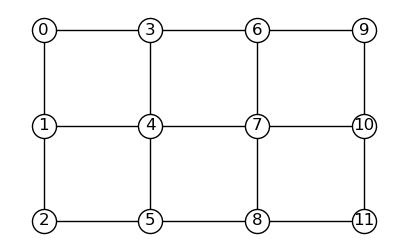

In [2]:
h,w = 3,4
X = [gm.Var(i,3) for i in range(h*w)]
tab = np.array([[1,0,0],[0,.9,0],[0,0,.8]])+.1
factors  = [gm.Factor([X[h*i+j],X[h*i+j+1]],tab) for i in range(w) for j in range(h-1)]
factors += [gm.Factor([X[h*i+j],X[h*i+j+h]],tab) for i in range(w-1) for j in range(h)]

pos = {i:(i//h,-(i%h)) for i in range(h*w)}

model = gm.GraphModel(factors)

order = list(range(w*h))            # default elimination order

fig,ax=plt.subplots(1,1,figsize=(5,3)); ax.set_axis_off();
gm.drawMarkovGraph(model,node_color='w',ax=ax, pos=pos);

### Sampling-based estimators

If we can generate exact samples from a distribution, we can use empirical frequncies to estimate values.  However, our model is not in a form that is easy to sample.  If we find the sequence of probabilities $p(X_0)$, $p(X_1|X_0)$, ... $p(X_n|\ldots)$, we can use forward sampling to draw a value $x_0$, then $x_1$ given our sampled $x_0$, and so forth.  But, finding these probabilities requires inference.  We can use a *junction tree* inference algorithm to compute these probabilities, after which we could then draw samples:

In [3]:
import pyGMs.wmb

jt = gm.wmb.JTree(model, order,'sum+')   # do the work to find f(x)'s normalized sampling distribution

samples = gm.d2t([jt.sample()[0] for s in range(100)])  # draw samples

beliefs = gm.misc.empirical( [ [X[0]], [X[3],X[4]] ] , samples, normalize=True)  # estimate frequencies

print('p(X0) ~ ',beliefs[0].table)
print('p(X3,X4) ~ ',beliefs[1].table)

p(X0) ~  [0.82 0.16 0.02]
p(X3,X4) ~  [[0.82 0.   0.  ]
 [0.   0.16 0.  ]
 [0.01 0.   0.01]]


### Basic sampling estimators

If we do not want to compute the exact $p(X)$ -- for example, if the graph has high width -- we can define a simpler proposal and use an importance sampling estimator.  Since sampling operators return both a configuration $x$ and the probability of generating $x$, a basic importance sampler is easy:

We first create an easy-to-sample-from distribution.  In this case, we will just select a tree-structured sub-graph of our full model. (Alternatively, we could get a distribution from an approximate inference algorithm, such as weighted mini-bucket (WMB), for example.)

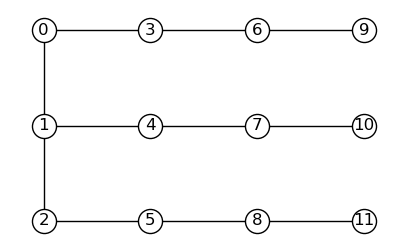

In [4]:
span_tree = factors[:h-1] + factors[w*(h-1):]
tree_submodel = gm.GraphModel(span_tree)
tree_order,_ = gm.eliminationOrder(tree_submodel, 'minwidth')
proposal = gm.wmb.JTree(tree_submodel, tree_order, 'sum+')  # cheap: tree is only width 1

fig,ax=plt.subplots(1,1,figsize=(5,3)); ax.set_axis_off();
gm.drawMarkovGraph(tree_submodel,node_color='w',ax=ax, pos=pos);

The importance sampling estimator draws samples $x\sim q(X)$, and assigns them an importance weight given by $w = f(x)/q(x)$.  Then, we can estimate queries using these weighted samples.  A common estimator is the self-normalized importance sampler, in which we collect the weights, normalize them, and then use the weighted empirical expectations for our queries:

In [5]:
draws = [ (x,model.logValue(x)-lnw) for s in range(100) for x,lnw in [proposal.sample()] ]
samples, log_weights = gm.d2t([x for x,wt in draws]), [lnw for x,lnw in draws]

weights_selfnorm = np.exp( np.array(log_weights) );
weights_selfnorm /= weights_selfnorm.sum()

beliefs = gm.misc.empirical( [ [X[0]], [X[3],X[4]] ] , samples, weights_selfnorm)  # estimate frequencies

print('p(X0) ~ ',beliefs[0].table)
print('p(X3,X4) ~ ',beliefs[1].table)

p(X0) ~  [0.76948977 0.22949689 0.00101335]
p(X3,X4) ~  [[8.48589703e-01 4.52602264e-04 6.57859913e-05]
 [1.78389829e-04 1.49170405e-01 4.06543144e-04]
 [1.19298477e-04 5.43693993e-04 4.73578802e-04]]


We can see this is reasonably accurate compared to the exact sampler with a similar number of draws.

### Online estimation of expectations

We may not want to store all of the samples we are drawing, since we are really only interested in the resulting estimates.  `pyGMs` has some data structures for maintaining online estimates of empirical quantities, specifically for Monte Carlo methods.

Suppose we want to estimate the expected value of some function, e.g. $g(x) = x_1/(x_2+1)$.  We can create an object that tracks this expectation:

In [6]:
g = lambda x: x[1]/(x[2]+1)

stats = gm.montecarlo.EmpiricalStatistics(g)

for s in range(100):
    x,lnw = proposal.sample(); 
    wt = np.exp(model.logValue(x)-lnw);
    stats.update(x,wt)
    if (s+1)%10==0: print(f'{s+1} samples, estimate: {stats()}')

10 samples, estimate: [0.02542452]
20 samples, estimate: [0.0270161]
30 samples, estimate: [0.02918323]
40 samples, estimate: [0.02555842]
50 samples, estimate: [0.02748369]
60 samples, estimate: [0.02935625]
70 samples, estimate: [0.02864389]
80 samples, estimate: [0.03172661]
90 samples, estimate: [0.03226535]
100 samples, estimate: [0.02947861]


We can also check some basic statistics about the data that have been accumulated, such as the "effective number of samples":

In [7]:
print(f'After {s} samples, our effective number of samples is {stats.neff}')

After 99 samples, our effective number of samples is [24.02650633]


If we wish to track multiple expectations, we can give them as a list:

In [8]:
g2 = lambda x: x[0]*x[1]

stats = gm.montecarlo.EmpiricalStatistics([g,g2])

for s in range(100):
    x,lnw = proposal.sample(); 
    wt = float(np.exp(model.logValue(x)-lnw));
    stats.update(x,wt)
    if (s+1)%10==0: print(f'{s+1} samples, estimate: {stats()}')

10 samples, estimate: [0.018726908109627634, 0.03745381621925527]
20 samples, estimate: [0.020126291365294504, 0.03522100988926538]
30 samples, estimate: [0.013811452958629889, 0.03255556768819902]
40 samples, estimate: [0.024242144038908744, 0.07532380469232358]
50 samples, estimate: [0.03600572948436801, 0.08289691206866122]
60 samples, estimate: [0.0451263744039589, 0.10069521561213966]
70 samples, estimate: [0.04112396253693945, 0.09504204675203781]
80 samples, estimate: [0.03940024988726575, 0.09706551627856194]
90 samples, estimate: [0.04378294685400673, 0.1057008421090813]
100 samples, estimate: [0.043878220116250186, 0.10782839198780628]


/var/folders/mk/c779r669401fcm1j1n9x37v80000gn/T/ipykernel_35444/3138104555.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  wt = float(np.exp(model.logValue(x)-lnw));


Often, what we want are the marginal probabilities of *many* sub-configurations of the model, e.g., the marginal distribution $p(X_1,X_2)$, etc. There is a specialized object for tracking the marginal probabilites of `VarSet`s:

In [9]:
marg = gm.montecarlo.EmpiricalMarginals( model.factors )  # get marginals of all factors
for s in range(100):
    x,lnw = proposal.sample(); 
    marg.update(x,np.exp(model.logValue(x)-lnw))
print(f'Marginal probability of 1st factor, mu(X{marg[0].vars}): \n{marg[0].table}')

Marginal probability of 1st factor, mu(X{0,1}): 
[[8.27255990e-01 6.92913150e-05 3.46283433e-08]
 [6.44571983e-04 1.51158744e-01 2.59366292e-05]
 [6.23310180e-07 3.49746268e-06 2.08413108e-02]]


If you would like to draw samples for a fixed amount of time, there is a helper function that can assist:

In [10]:
stats.reset()                  # reset sample accumulation

for t in gm.timelimit(10):        # ~10 second time limit
    x,lnw = proposal.sample();
    stats.update(x,np.exp(model.logValue(x)-lnw))
print(f'Drew {stats.nsamples} samples, Neff {stats.neff}: {stats()}')

Drew 14399.0 samples, Neff [2547.92546172]: [array([0.04051948]), array([0.11051306])]


## Markov Chain Monte Carlo

The other basic strategy of Monte Carlo methods is to form a sequential, stochastic process ("Markov chain") which, when simulated, will *eventually* result in a sample from the target distribution $p(X)$.  There are many approaches, but the two most common are Gibbs sampling and its variants, and the slightly more general Metropolis-Hastings algorithm.

In general, since MCMC approaches are designed to give samples (asymptotically) from $p(X)$, we do not associate the samples with a weight.

### Gibbs Sampling
The simplest MCMC sampler is the Gibbs sampler, which stochastically updates one (or a few) variables at a time, given the current values of the other variables.

In [11]:
all_zeros = (0,)*len(model.X)   # we may want to start the chain in a known state

gs = pyGMs.montecarlo.GibbsSampler(model,chains=1, init_states=[all_zeros])

Each call to ``sample()`` performs one or more forward steps of the Markov chain simulation process.  You can "burn in" (move away from the initial condition) $T$ steps by calling `sample()` $T$ times, or by calling ``sample(T)``.  Then, to decimate the chain by some amount $t$, you can generate each subsequent sample by calling ``sample(t)``.

In [12]:
_ = gs.sample(10)                               # burn in by 10 steps
samples = [gs.sample(5)[0] for i in range(100)] # Generate 100 samples, each 5 steps apart

beliefs = gm.misc.empirical( [ [X[0]], [X[3],X[4]] ] , samples, normalize=True)  # estimate frequencies

print('p(X0) ~ ',beliefs[0].table)
print('p(X3,X4) ~ ',beliefs[1].table)

p(X0) ~  [0.99 0.01 0.  ]
p(X3,X4) ~  [[1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


### Metropolis-Hastings

#### <span style="color:red"> TODO: TBD </span>

### Annealed Importance Sampling

AIS is an algorithm that uses MCMC to produce samples, but does so within an importance sampling framework, so that the nice properties of importance sampling can be preserved.  It does more work per sample than standard IS, but (hopefully) results in samples that are closer to the target distribution $p(X)$, and thus a higher effective sample size.

To use AIS, we need a "base" proposal distribution that is represented as a Bayesian network, so that it can be both forward-sampled and used in MCMC.  For demonstration, we will make a base that is an independent distribution, with single-variable probabilities obtained through a WMB approximation:

In [13]:
wmb = gm.wmb.WMB(model,order,iBound=1,weights='sum+')
wmb.msgForward(0.5,0.0)
mu = wmb.msgBackward(0,0, beliefs=[gm.VarSet([x]) for x in model.X])
base = gm.GraphModel([mu[f] for f in mu])

# Can verify that the resulting model is a Bayes net, if desired:
# base_order=gm.bnOrder(base)
# base.isBN()
# gm.bnSample(base,base_order)

In [15]:
gm.montecarlo.AnnealedImportanceSampling(model,None,base,T=10)

((0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), array([-6.47120408]))

In [16]:
draws = [ gm.montecarlo.AnnealedImportanceSampling(model,None,base,T=10,K=5) for s in range(100)]

samples, log_weights = [x for x,wt in draws], [float(wt) for x,wt in draws]

weights_selfnorm = np.exp(model.logValue(samples)-log_weights);
weights_selfnorm /= weights_selfnorm.sum()

beliefs = gm.misc.empirical( [ [X[0]], [X[3],X[4]] ] , samples, weights_selfnorm)  # estimate frequencies

print('p(X0) ~ ',beliefs[0].table)
print('p(X3,X4) ~ ',beliefs[1].table)

p(X0) ~  [9.99968427e-01 1.11990054e-08 3.15615851e-05]
p(X3,X4) ~  [[9.99999989e-01 0.00000000e+00 0.00000000e+00]
 [1.11990054e-08 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]


/var/folders/mk/c779r669401fcm1j1n9x37v80000gn/T/ipykernel_35444/376270306.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  samples, log_weights = [x for x,wt in draws], [float(wt) for x,wt in draws]


In [17]:
margIS  = gm.montecarlo.EmpiricalMarginals( model.factors ) 

base_order=gm.bnOrder(base)
for s in range(100):
    x,lnw = gm.bnSample(base, base_order)
    margIS.update(x,np.exp(model.logValue(x)-lnw))
    
print(f'Base distribution IS gives Neff={margIS.neff} at {margIS.nsamples} samples')

Base distribution IS gives Neff=[2.28966462] at 100.0 samples


In [18]:
margAIS = gm.montecarlo.EmpiricalMarginals( model.factors ) 

T=20; K=1;
for s in range(100):
    x,lnw = gm.montecarlo.AnnealedImportanceSampling(model,None,base,T=T,K=K)
    margAIS.update(x,np.exp(model.logValue(x)-lnw))
    
print(f'AIS with {T} temps, {K} step(s) per temp gives Neff={margAIS.neff} at {margAIS.nsamples} samples')

AIS with 20 temps, 1 step(s) per temp gives Neff=[3.96571482] at 100.0 samples
